In [37]:
import numpy as np
import matplotlib.pyplot as plt
import struct
import random
from array import array
from os.path import join

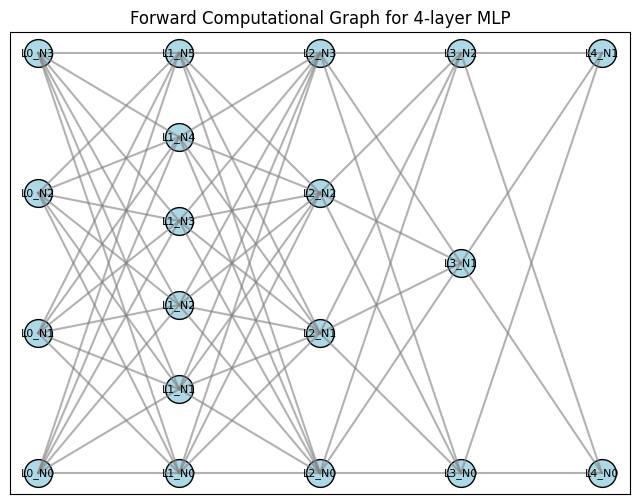

Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed
MLP Accuracy: 98.12%


In [38]:
# Define the MLP structure
layers = [4, 6, 4, 3, 2]  # Input layer + hidden layers + output layer

def draw_mlp_graph(layers):
    plt.figure(figsize=(8, 6))
    x_positions = []
    y_positions = []
    
    for i, num_nodes in enumerate(layers):
        x = [i] * num_nodes
        y = np.linspace(0, 1, num_nodes)
        x_positions.append(x)
        y_positions.append(y)
        plt.scatter(x, y, s=400, color='lightblue', edgecolors='black')
        for j in range(num_nodes):
            plt.text(x[j], y[j], f'L{i}_N{j}', ha='center', va='center', fontsize=8)
    
    for i in range(len(layers) - 1):
        for j in range(layers[i]):
            for k in range(layers[i + 1]):
                plt.plot([x_positions[i][j], x_positions[i + 1][k]],
                         [y_positions[i][j], y_positions[i + 1][k]],
                         color='gray', alpha=0.6)
    
    plt.title("Forward Computational Graph for 4-layer MLP")
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Draw the graph
draw_mlp_graph(layers)

# Activation functions and their derivatives
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return (x > 0).astype(float)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

class MLP:
    def __init__(self, input_dim, layer_dims, activation='relu'):
        self.layers = len(layer_dims)
        self.activation_func = relu if activation == 'relu' else sigmoid
        self.activation_derivative = relu_derivative if activation == 'relu' else sigmoid_derivative
        
        # Initialize weights and biases
        self.weights = [np.random.randn(layer_dims[i-1], layer_dims[i]) * 0.01 for i in range(1, self.layers)]
        self.biases = [np.zeros((1, layer_dims[i])) for i in range(1, self.layers)]
    
    def forward(self, X):
        self.a = [X]
        self.z = []
        for i in range(self.layers - 1):
            z = np.dot(self.a[-1], self.weights[i]) + self.biases[i]
            a = self.activation_func(z)
            self.z.append(z)
            self.a.append(a)
        return self.a[-1]
    
    def backward(self, X, Y, learning_rate=0.01):
        m = Y.shape[0]
        dZ = self.a[-1] - Y
        
        for i in reversed(range(self.layers - 1)):
            dW = np.dot(self.a[i].T, dZ) / m
            dB = np.sum(dZ, axis=0, keepdims=True) / m

            # Ensure dZ shape matches the layer
            if i > 0:
                dZ = np.dot(dZ, self.weights[i].T) * self.activation_derivative(self.z[i-1])

            self.weights[i] -= learning_rate * dW
            self.biases[i] -= learning_rate * dB


class CNN:
    def __init__(self, input_shape, filter_shape, num_filters, fc_layer_dims, activation='relu'):
        self.activation_func = relu if activation == 'relu' else sigmoid
        self.activation_derivative = relu_derivative if activation == 'relu' else sigmoid_derivative
        
        self.num_filters = num_filters
        self.filter_shape = filter_shape
        self.filters = np.random.randn(num_filters, *filter_shape) * 0.01
        
        # Fully connected layer
        self.mlp = MLP(np.prod(input_shape), fc_layer_dims, activation)
    
    def convolve(self, X):
        h, w = X.shape
        fh, fw = self.filter_shape
        output_dim = (h - fh + 1, w - fw + 1, self.num_filters)
        conv_output = np.zeros(output_dim)
        
        for i in range(output_dim[0]):
            for j in range(output_dim[1]):
                for f in range(self.num_filters):
                    conv_output[i, j, f] = np.sum(X[i:i+fh, j:j+fw] * self.filters[f])
        
        return self.activation_func(conv_output)
    
    def forward(self, X):
        conv_out = self.convolve(X)
        flat_output = conv_out.flatten().reshape(1, -1)
        return self.mlp.forward(flat_output)
    
    def backward(self, X, Y, learning_rate=0.01):
        self.mlp.backward(X.flatten().reshape(1, -1), Y, learning_rate)
        # Backpropagation for CNN layers would require computing gradients for filters, omitted for brevity.

# Load MINST dataset
# Load MINST dataset
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Convert lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Train and validate the MLP
mlp = MLP(784, [784, 128, 64, 10])


for epoch in range(10):
    for i in range(len(x_train)):
        x = x_train[i].flatten().reshape(1, -1) / 255.0
        y = np.zeros((1, 10))
        y[0, y_train[i]] = 1
        mlp.forward(x)
        mlp.backward(x, y, learning_rate=0.01)
    
    print(f"Epoch {epoch+1} completed")

# Evaluate the MLP
correct = 0
for i in range(len(x_test)):
    x = x_test[i].flatten().reshape(1, -1) / 255.0
    prediction = np.argmax(mlp.forward(x))
    if prediction == y_test[i]:
        correct += 1

accuracy = correct / len(x_test)
print(f"MLP Accuracy: {accuracy * 100:.2f}%")